# MNISTM-Digit Recognizer Using CNN with Keras

### MNIST Dataset: 
##### It is a large database of handwritten digits that is commonly used for training various image processing systems. This dataset is considered to be the "hello world" dataset for Computer Vision. 
##### This dataset contains images of handwritten digits. It has 60,000 rgb images under the training set and 10,000 rgb images under the test set. We will use the Keras library with Tensorflow backend to classify the images.

### Import Libraries
###### First, we import all the necessary libraries required.

In [33]:
import torchvision
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf
import keras
import torch
from PIL import Image
from torchvision.datasets import VisionDataset
from torchvision.datasets.utils import download_and_extract_archive
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms 
from sklearn.metrics import confusion_matrix, classification_report

### Loading Data
##### The dataset will be downloaded from the source code obtained from https://github.com/liyxi/mnist-m/blob/main/mnist_m.py
##### It contains a raw and a processed folder which contains the training and test sets. Both these files are in .pt format.

In [2]:
class MNISTM(VisionDataset):
    """MNIST-M Dataset.
    """

    resources = [
        ('https://github.com/liyxi/mnist-m/releases/download/data/mnist_m_train.pt.tar.gz',
         '191ed53db9933bd85cc9700558847391'),
        ('https://github.com/liyxi/mnist-m/releases/download/data/mnist_m_test.pt.tar.gz',
         'e11cb4d7fff76d7ec588b1134907db59')
    ]

    training_file = "mnist_m_train.pt"
    test_file = "mnist_m_test.pt"
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        """Init MNIST-M dataset."""
        super(MNISTM, self).__init__(root, transform=transform, target_transform=target_transform)

        self.train = train

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError("Dataset not found." +
                               " You can use download=True to download it")

        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file

        print(os.path.join(self.processed_folder, data_file))

        self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))

    def __getitem__(self, index):
        """Get images and target for data loader.
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.squeeze().numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        """Return size of dataset."""
        return len(self.data)

    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    @property
    def class_to_idx(self):
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self):
        return (os.path.exists(os.path.join(self.processed_folder, self.training_file)) and
                os.path.exists(os.path.join(self.processed_folder, self.test_file)))

    def download(self):
        """Download the MNIST-M data."""

        if self._check_exists():
            return

        os.makedirs(self.raw_folder, exist_ok=True)
        os.makedirs(self.processed_folder, exist_ok=True)

        # download files
        for url, md5 in self.resources:
            filename = url.rpartition('/')[2]
            download_and_extract_archive(url, download_root=self.raw_folder,
                                         extract_root=self.processed_folder,
                                         filename=filename, md5=md5)

        print('Done!')

    def extra_repr(self):
        return "Split: {}".format("Train" if self.train is True else "Test")

##### After running the above source code where we defined a class named as MNISTM which will be used for downloading the datasets. Let us load the training and test dataset using the above defined procedure

In [3]:
train = MNISTM(r'C:\Users\KIT\OneDrive\Documents',train = True,transform= torchvision.transforms.ToTensor(), target_transform = torchvision.transforms.Grayscale(num_output_channels=1), download=True)

C:\Users\KIT\OneDrive\Documents\MNISTM\processed\mnist_m_train.pt


##### The imported train and test dataset is having the data type as uint8 and in the form of a tensor. So we are having the images with 3 channels (red, green and blue). The train.pt and test.pt were imported using torch.load() as:

In [10]:
trainset = torch.load(r'C:\Users\KIT\OneDrive\Documents\MNISTM\processed\mnist_m_train.pt')

In [11]:
trainset

(tensor([[[[ 60,  77, 133],
           [ 61,  78, 134],
           [ 62,  79, 135],
           ...,
           [ 57,  76, 132],
           [ 57,  76, 132],
           [ 57,  77, 130]],
 
          [[ 60,  77, 133],
           [ 61,  78, 134],
           [ 61,  78, 134],
           ...,
           [ 57,  76, 132],
           [ 57,  76, 132],
           [ 57,  76, 132]],
 
          [[ 61,  78, 134],
           [ 61,  78, 134],
           [ 61,  78, 134],
           ...,
           [ 56,  75, 131],
           [ 56,  75, 131],
           [ 57,  76, 132]],
 
          ...,
 
          [[ 57,  76, 134],
           [ 57,  77, 130],
           [ 57,  77, 130],
           ...,
           [  6,  34,  35],
           [  6,  35,  33],
           [  7,  36,  32]],
 
          [[ 58,  77, 135],
           [ 58,  77, 133],
           [ 57,  77, 130],
           ...,
           [  9,  37,  38],
           [  8,  37,  35],
           [  8,  37,  35]],
 
          [[ 57,  73, 133],
           [ 62,  78

In [6]:
test = MNISTM(r'C:\Users\KIT\OneDrive\Documents',train = False,transform= torchvision.transforms.Grayscale(num_output_channels=1), target_transform = torchvision.transforms.ToTensor(), download=True)

C:\Users\KIT\OneDrive\Documents\MNISTM\processed\mnist_m_test.pt


In [9]:
testset =torch.load(r'C:\Users\KIT\OneDrive\Documents\MNISTM\processed\mnist_m_test.pt')

In [12]:
testset

(tensor([[[[ 63,  78, 133],
           [ 59,  76, 132],
           [ 65,  81, 140],
           ...,
           [ 15,  40,  45],
           [  8,  37,  35],
           [  8,  37,  35]],
 
          [[ 62,  79, 135],
           [ 61,  80, 136],
           [ 61,  80, 138],
           ...,
           [ 11,  35,  45],
           [  9,  34,  38],
           [ 12,  41,  39]],
 
          [[ 61,  78, 132],
           [ 63,  82, 138],
           [ 56,  75, 131],
           ...,
           [ 13,  36,  54],
           [ 10,  35,  42],
           [  9,  37,  38]],
 
          ...,
 
          [[ 73,  86, 130],
           [ 70,  82, 130],
           [ 66,  78, 128],
           ...,
           [ 32,  53,  72],
           [ 41,  61,  86],
           [ 10,  31,  52]],
 
          [[ 62,  75, 119],
           [ 47,  60, 105],
           [ 44,  56, 104],
           ...,
           [ 39,  60,  81],
           [ 30,  50,  77],
           [  7,  27,  52]],
 
          [[ 23,  36,  78],
           [ 32,  45

### Data Preperation
##### Convert train and test file into independent x_train, x_test and dependent labels x_test, y_test 

In [17]:
x_train, y_train = trainset

In [18]:
x_test, y_test = testset

#### Let us visualize the label output variable and check if they are balanced or imbalanced. Also before that convert the data fetaures including labels into np array

In [20]:
y_train = np.array(y_train)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

<AxesSubplot:ylabel='count'>

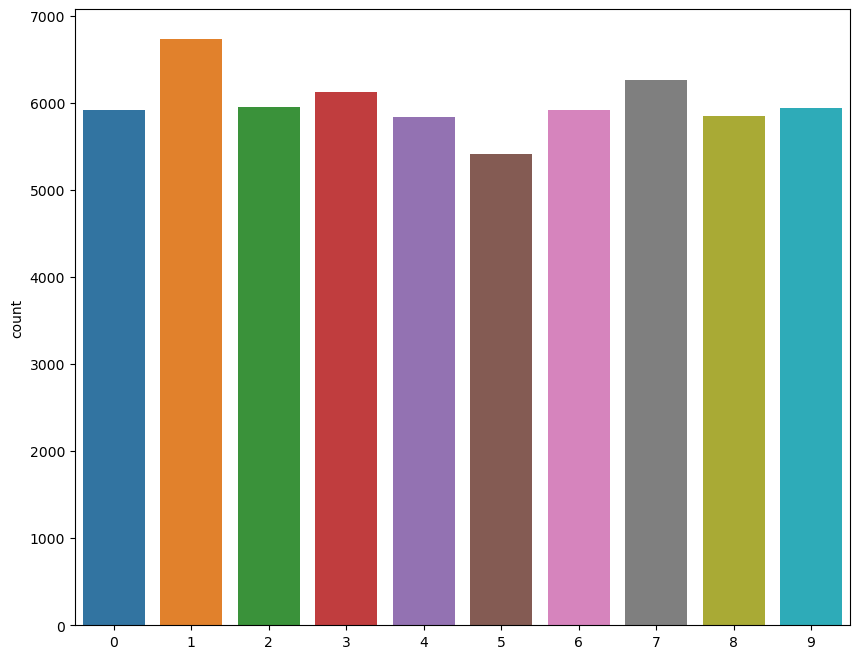

In [21]:
import seaborn as sns
plt.figure(figsize = (10,8))
sns.countplot(y_train)

C:\Users\KIT\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

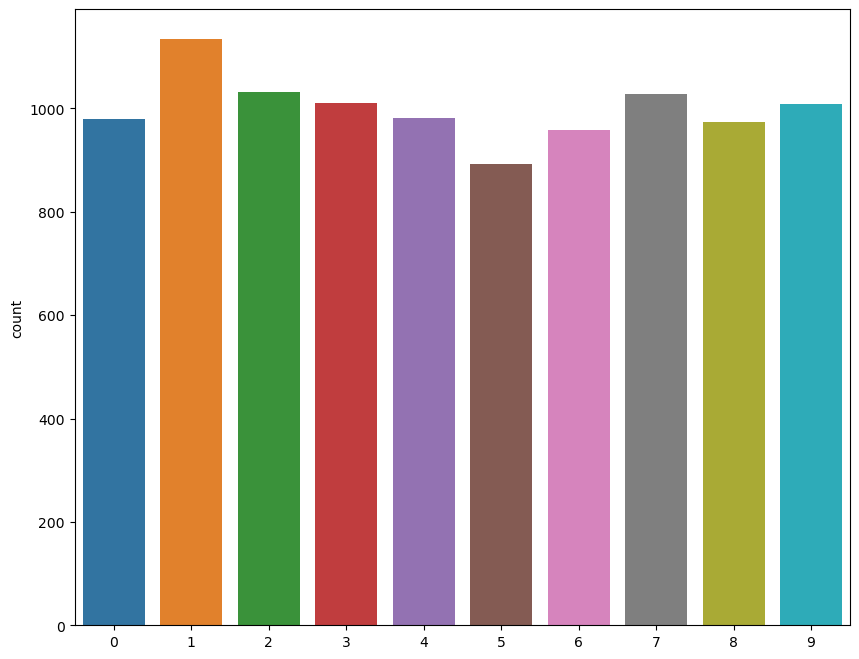

In [22]:
plt.figure(figsize = (10,8))
sns.countplot(y_test)

#### Check for missing values

In [23]:
np.isnan(x_train).sum()

0

In [24]:
np.isnan(y_train).sum()

0

In [25]:
np.isnan(x_test).sum()

0

In [26]:
np.isnan(y_test).sum()

0

##### There are no missing values in the feature and label columns

#### Shape of the data

In [27]:
x_train.shape

(60000, 28, 28, 3)

In [28]:
x_test.shape

(10000, 28, 28, 3)

#### The shape of x_train is (60000, 28, 28, 3). Each image has 28 x 28 resolution with 3 channels of RGB. The shape of x_test is (10000, 28, 28, 3). The input shape that a CNN accepts should be in a specific format. If you are using Tensorflow, the format should be (batch, height, width, channels).

### Visualize the classes of the MNISTM dataset class labels

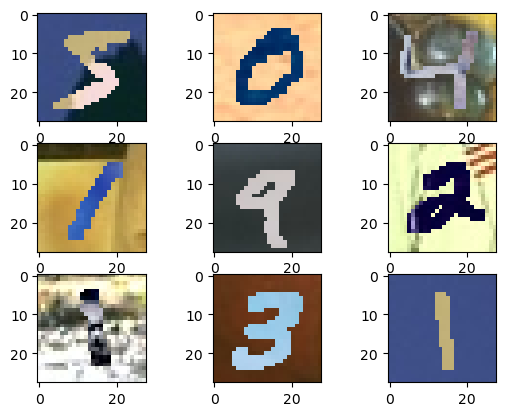

In [29]:
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

### One Hot Encoding

##### Now, we need to one-hot encode the labels i.e. Y_train and Y_test. In one-hot encoding an integer is converted to an array which contains only one ‘1’ and the rest elements are ‘0’.

In [30]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Normalization

##### Here we’ve rescaled the image data so that each pixel lies in the interval [0, 1] instead of [0, 255]. It is always a good idea to normalize the input so that each dimension has approximately the same scale.

In [34]:
x_train = tf.cast(x_train, 'float32')
x_test = tf.cast(x_test, 'float32')

In [35]:
x_train/=255
x_test/=255

In [39]:
x_train = np.array(x_train)

## Splitting of trainset into train and validation set

In [41]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=42)

## Model Evaluation

### Let’s create the model that will classify the images

#### The general architecture of a convolutional neural network is:

###### 1. convolution layers, followed by pooling layers

###### 2. fully-connected layers

###### 3. a final fully-connected softmax layer
#####  The first is the convolutional (Conv2D) layer. The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter.  Further, The Flatten layer is use to convert the final feature maps into a one single 1D vector. In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [42]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,3))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer01 = Activation('relu')                     # activation
model.add(convLayer01)

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer02)

# Convolution Layer 3
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6                       
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax'))  

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 24, 24, 32)        0

 Keras allows us to specify the number of filters we want and the size of the filters. So, in our first layer, 32 is number of filters and (3, 3) is the size of the filter. We also need to specify the shape of the input which is (28, 28, 3), but we have to specify it only once.

The second layer is the Activation layer. We have used ReLU (rectified linear unit) as our activation function. ReLU function is f(x) = max(0, x), where x is the input. It sets all negative values in the matrix ‘x’ to 0 and keeps all the other values constant. It is the most used activation function since it reduces training time and prevents the problem of vanishing gradients.

The third layer is the MaxPooling layer. MaxPooling layer is used to down-sample the input to enable the model to make assumptions about the features so as to reduce over-fitting. It also reduces the number of parameters to learn, reducing the training time.

It’s a best practice to always do BatchNormalization. BatchNormalization normalizes the matrix after it is been through a convolution layer so that the scale of each dimension remains the same. It reduces the training time significantly.

After creating all the convolutional layers, we need to flatten them, so that they can act as an input to the Dense layers.

Dense layers are keras’s alias for Fully connected layers. These layers give the ability to classify the features learned by the CNN.

Dropout is the method used to reduce overfitting. It forces the model to learn multiple independent representations of the same data by randomly disabling neurons in the learning phase. In our model, dropout will randomnly disable 20% of the neurons.

The second last layer is the Dense layer with 10 neurons. The neurons in this layer should be equal to the number of classes we want to predict as this is the output layer.

The last layer is the Softmax Activation layer. Softmax activation enables us to calculate the output based on the probabilities. Each class is assigned a probability and the class with the maximum probability is the model’s output for the input.

### Model Compilation

In [44]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

The cross-entropy loss calculates the error rate between the predicted value and the original value. The formula for calculating cross-entropy loss is given here. Categorical is used because there are 10 classes to predict from. If there were 2 classes, we would have used binary_crossentropy.

The Adam optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is responsible for updating the weights of the neurons via backpropagation. It calculates the derivative of the loss function with respect to each weight and subtracts it from the weight.


### Data Augumentation

To reduce over-fitting, we use another technique known as Data Augmentation. Data augmentation rotates, shears, zooms, etc the image so that the model learns to generalize and not remember specific data. If the model overfits, it will perform very well on the images that it already knows but will fail if new images are given to it.

In [46]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

This is how we can do Data Augmentation in Keras. You can play with the values and check if it improves the accuracy of the model.




We have to create batches, so that we use less memory. Moreover, we can also train our model faster by creating batches. Here we are using batch of 64, so the model will take 64 images at a time and train on them.

In [47]:
train_generator = gen.flow(x_train, y_train, batch_size=64)

### Training of the Model

In [48]:
batch_size = 64
epochs = 10
history = model.fit_generator(train_generator, steps_per_epoch=x_train.shape[0] // batch_size, epochs = epochs, verbose=1, 
                    validation_data = (x_val,y_val), validation_steps=x_val.shape[0] // batch_size)

C:\Users\KIT\AppData\Local\Temp\ipykernel_14540\4013605225.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=x_train.shape[0] // batch_size, epochs = epochs, verbose=1,


Epoch 1/10
843/843 [==============================] - 194s 226ms/step - loss: 0.4184 - accuracy: 0.8629 - val_loss: 0.2540 - val_accuracy: 0.9150
Epoch 2/10
843/843 [==============================] - 188s 223ms/step - loss: 0.1760 - accuracy: 0.9439 - val_loss: 0.1609 - val_accuracy: 0.9462
Epoch 3/10
843/843 [==============================] - 188s 223ms/step - loss: 0.1359 - accuracy: 0.9558 - val_loss: 0.1415 - val_accuracy: 0.9557
Epoch 4/10
843/843 [==============================] - 190s 225ms/step - loss: 0.1160 - accuracy: 0.9627 - val_loss: 0.1038 - val_accuracy: 0.9657
Epoch 5/10
843/843 [==============================] - 190s 225ms/step - loss: 0.1019 - accuracy: 0.9672 - val_loss: 0.0963 - val_accuracy: 0.9705
Epoch 6/10
843/843 [==============================] - 190s 226ms/step - loss: 0.0934 - accuracy: 0.9702 - val_loss: 0.1025 - val_accuracy: 0.9673
Epoch 7/10
843/843 [==============================] - 196s 233ms/step - loss: 0.0842 - accuracy: 0.9731 - val_loss: 0.0982 -

#### We achived 94.80% accuracy using this simple model. To improve the result, we can do ensembling of models.

### Training and Validation Curves

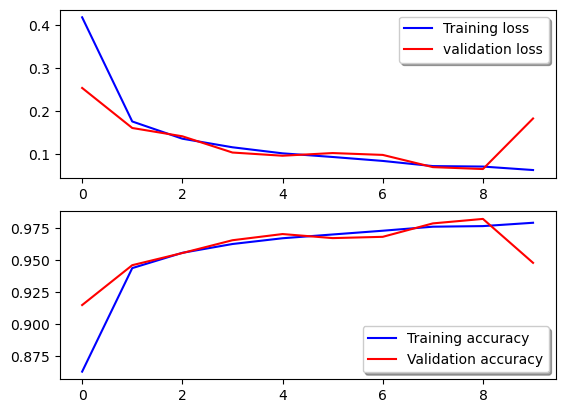

In [49]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [52]:
score = model.evaluate(x_val, y_val)
print('Val accuracy:', score[1])

188/188 [==============================] - 5s 27ms/step - loss: 0.1830 - accuracy: 0.9480
Val accuracy: 0.9480000138282776


#### Model Prediction

In [53]:
Y_pred = model.predict(x_val)

In [54]:
Y_pred = np.argmax(Y_pred, axis = 1)

In [55]:
Y_pred

array([1, 3, 8, ..., 7, 2, 5], dtype=int64)

In [56]:
y_val = np.argmax(y_val, axis =1)

In [57]:
y_val

array([7, 3, 8, ..., 7, 2, 5], dtype=int64)

### Confusion Matrix for model performance

In [58]:
confusion_matrix(y_val,Y_pred)

array([[597,  18,   0,   1,   1,   0,   3,   0,   0,   4],
       [  0, 651,   3,   0,   0,   0,   0,   0,   0,   0],
       [  1,  20, 546,   0,   0,   0,   0,   0,   2,   3],
       [  0,  25,   6, 553,   0,   2,   2,   1,   0,   0],
       [  0,  29,   0,   0, 545,   0,   0,   1,   0,   5],
       [  1,  14,   0,   4,   0, 517,  10,   0,   4,   1],
       [  0,  16,   0,   0,   1,   0, 563,   0,   0,   0],
       [  0,  43,   8,   0,   0,   0,   0, 580,   1,   1],
       [  2,  29,   1,   0,   1,   3,   0,   0, 547,   2],
       [  1,  21,   0,   2,  10,   2,   0,   5,   2, 589]], dtype=int64)

## Yes it did quite well

## Save the Model

In [77]:
model.save('cnnModel.h5')